In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-dataset/test.csv
/kaggle/input/train-dataset/train.csv
/kaggle/input/test-orig/test.csv
/kaggle/input/test-after/test.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from scipy import stats
import seaborn as sns
from copy import deepcopy

%matplotlib inline


In [5]:
'''
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows',1000)
'''

"\npd.set_option('display.max_columns', 1000)\npd.set_option('display.max_rows',1000)\n"

## Posing this as a Machine Learning Problem.
* we have train data of shape - (188318, 132). And the target feature is a a continous numerical feature.
* Train dataset contains categorical and continuous features. 
* Target variable is a Loss (claim severity) which is numeric in type. As the target variable is numeric and loss value we can pose this problem as a Regression problem. 
* It is also a supervised Machine learning problem as we have target values for train data.
* GOAL:- Our task is to predict how severe the claim will or might be for a new household, predict future loss based on given features.


## Load Data
* loading train data into train_data dataframe
* loading test data into test_data dataframe

In [6]:
train_data = pd.read_csv('/kaggle/input/train-dataset/train.csv')
test_data  = pd.read_csv('/kaggle/input/test-orig/test.csv')

print('Shape of Train data:',train_data.shape)
print('Shape of Test  data:',test_data.shape)

Shape of Train data: (188318, 132)
Shape of Test  data: (125546, 131)


## Observation:
* Train Data :  188318 rows and 132 features/columns along with target variables.
* Test Data : 129446 rows and 132 features/columns where target feature is not present.
* All feature names are made anonymous. So understanding features and feature engineering is a hard task to do.


## Getting High level overview of the data.

In [7]:
print('Train data high level overview :')
print(train_data.info())
print('-'*50)
print('Test data high level overview :')
print(test_data.info())

Train data high level overview :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB
None
--------------------------------------------------
Test data high level overview :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(1), object(116)
memory usage: 125.5+ MB
None


## Observations:
* There are a total of 130 distinct features excluding target feature and id feature. These features contain categorical and numerical data types.
* Out of 130 features, 116 are categorical and 14 are numerical. We noticed that there are no missing values in the train dataset. This shows that Allstate provided highly user friendly pre processed data.


## Seperating categorical and continous features.

In [8]:
# https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical

categorical_features = list(train_data.select_dtypes(include=['object']).columns)
print("Categorical features in Train data : {} features".format(len(categorical_features)))

Categorical features in Train data : 116 features


In [9]:
# https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical
continous_features = [i for i in list(train_data.select_dtypes(include=['float64', 'int64']).columns) if i not in ['loss', 'id']]
print("Continuous features in Train data : {} features".format(len(continous_features)))

Continuous features in Train data : 14 features


## Checking for missing values in the dataset.

In [10]:
print('Missing values in Train data:',pd.isnull(train_data).values.any())
print('Missing values in Test  data:',pd.isnull(test_data).values.any())

Missing values in Train data: False
Missing values in Test  data: False


## Observation:
* as there are no missing values in train and test data, we can say that this data is already pre processed.
* if there are missing values in the data , we need to think of alternatives like removing those rows or filling those values with mean values to take care of missing data.

## Unique values in categorical features
* Finding number of unique calues present in each categorical features and loading them into a dataframe.

In [11]:
unique_in_categorical = []
for i in categorical_features:
    unique_in_categorical.append(len(train_data[i].unique()))

# Creating a dataframe which contains number of unique values and their correspoding deature names.
unique_categories = pd.DataFrame()
unique_categories['category name'] = categorical_features
unique_categories['unique_values'] = unique_in_categorical
print(unique_categories.head())

  category name  unique_values
0          cat1              2
1          cat2              2
2          cat3              2
3          cat4              2
4          cat5              2


In [12]:
a=max(unique_categories['unique_values'])
print('Maximum number of unique values in a single categorical feature is :',a)

Maximum number of unique values in a single categorical feature is : 326


## Observation:
* There are so many features that have very less unique values.
* A catergorical feature that has maximum number of unique values is 326. when you do OHE for this feature we get a vector of lenght 326 which is quite large and may lead to curse of dimensionality.

In [13]:
x = unique_categories[unique_categories.unique_values >= 10]
print(x.shape)

(17, 2)


## Observation:
* There are only 17 categorical features in which they have more than 10 unique values in them

## Plots for unique values in features.

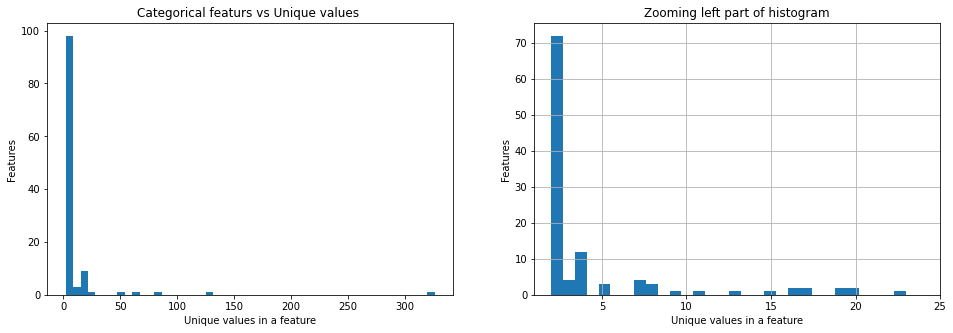

In [14]:
#https://github.com/dnkirill/allstate_capstone/blob/master/part1_data_discovery.ipynb
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(16,5)
ax1.hist(unique_categories.unique_values, bins=50)
ax1.set_title('Categorical featurs vs Unique values ')
ax1.set_xlabel('Unique values in a feature')
ax1.set_ylabel('Features')


values = unique_categories[unique_categories.unique_values <= 25].unique_values
ax2.set_xlim(1,25)
ax2.hist(values, bins=30)
ax2.set_title('Zooming left part of histogram')
ax2.set_xlabel('Unique values in a feature')
ax2.set_ylabel('Features')
ax2.grid(True)

## Observation:
* From the above plto we noticed that there are alost 100 features which have less than 10 unique values in each feature.
* There is a feature which have more than 300 unique values in it,and we have seen that in above code as well.
* Tried to plot the zoomed image to see how these distributions occur, we can see that there are very few number of features that has more number of unique values.

## Plots for continous features.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9948db5490>,
      dtype=object)

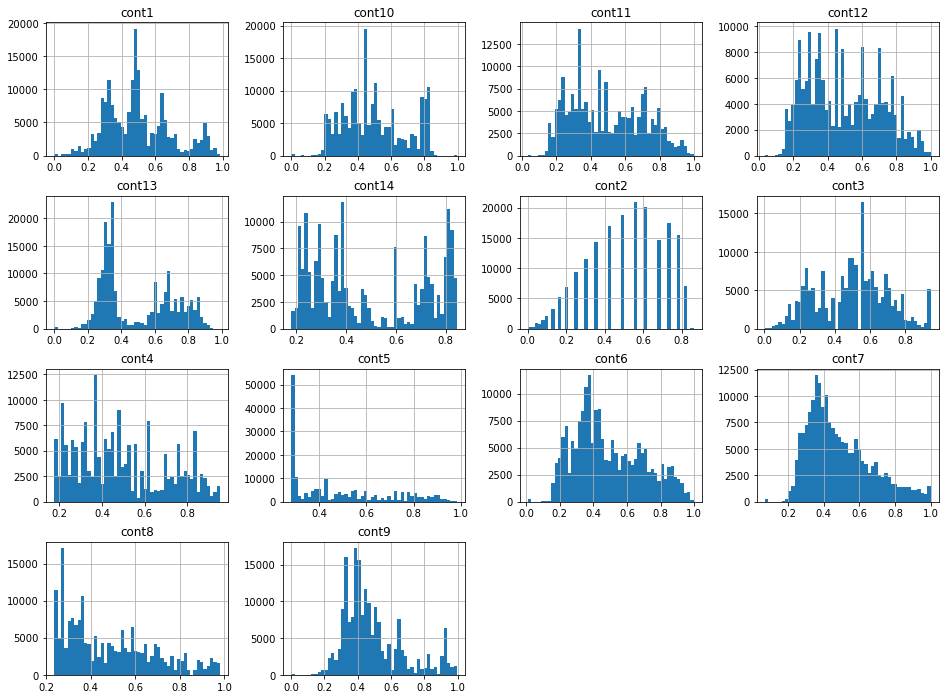

In [15]:
train_data[continous_features].hist(bins=50, figsize=(16,12))

## Observation:
* we can notice that distributions of each of the continuous features vary a lot.
* There are a lot of spikes in each of the plots. so ther is no uniformity in PDF Of these continous features. 
* cont2 feature is actually looking like a normal distribution but we cant talk about what is that feature as theya are made anonymous

## Checking Box plot of continous features

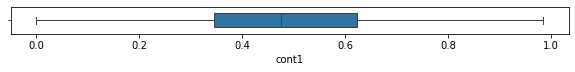

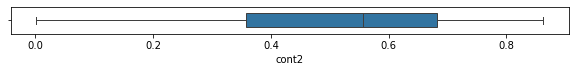

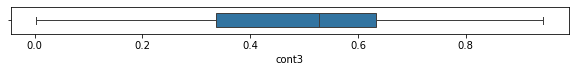

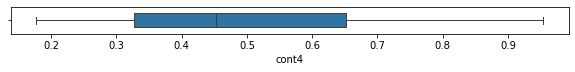

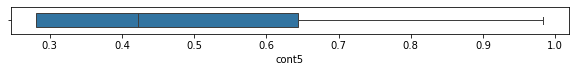

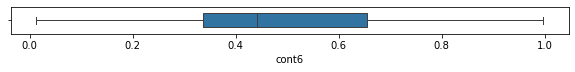

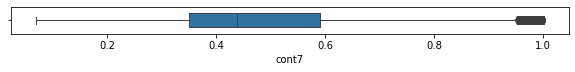

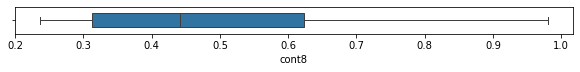

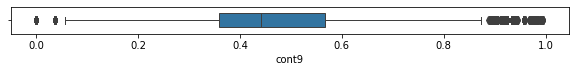

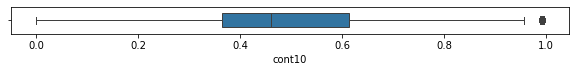

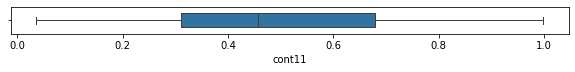

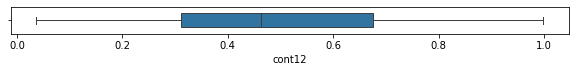

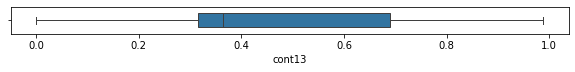

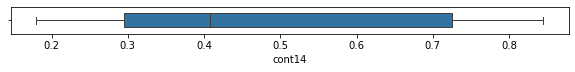

In [16]:
for i in continous_features:
    plt.figure(figsize = (10,0.5))
    sns.boxplot(x = train_data[i],width = 0.5,linewidth = 1.0, showfliers = True)

## Observations:
* we can see that most of the mean values for the continous fearures are lying around 0.5.
* all values lie between 0 and 1.
* it shows that data is already normalized.

## Checking Describe function on continous features.

In [17]:
train_data[continous_features].describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848


## Observation:
* we noticed that mean value of all continous features is around 0.5 whihc is really good and we can say that Allstate did pre processing and then gave the data.
* All the contious features are in range of [0,1] whcih is really good.

## Checking correlation between continous features.

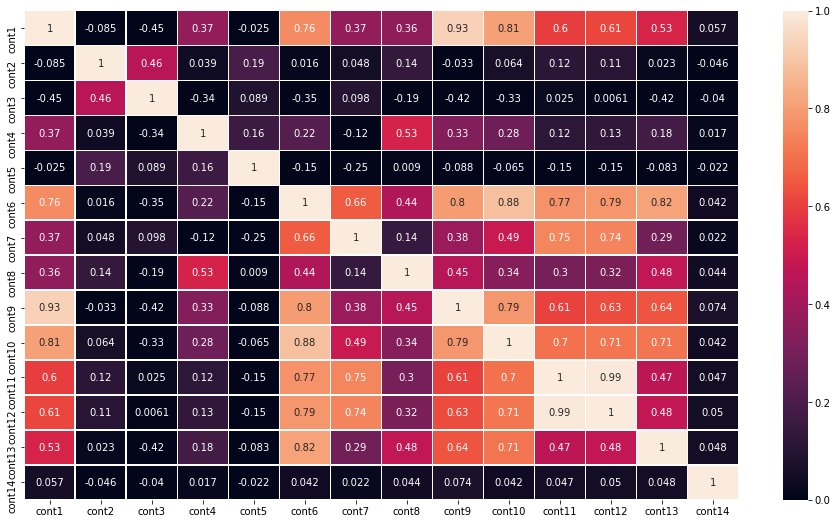

In [18]:
plt.subplots(figsize=(16,9))
correlation_matrix = train_data[continous_features].corr()
sns.heatmap(correlation_matrix, annot=True,vmin=0, vmax=1,linewidths=.5)

## Observation:
* In the above heat man we can notice that light colour block indicates high correlation and dark color indicates less similrity.
* There are a couple of features which are higly correlated. for example see cont 14 and cont 12 - they have a correlation value of 0.99 which is almost the max that it can get. 
* so we can drop some features which are highly correlated and train model to see if it hits in any performance drop.
* On the other hand as we dont know anything specific abotu data or the feature names we cant blinldly go an drop features. it might result in worse models as well.
* so tacking these kinds of data is a bit tough. we actually need to train model with and without drop in models and have to decide what is right thing to do.
* Cont11 and Cont12 are very well coreleated. im thinking to drop atleast one of those features.

## Analysing Target variable

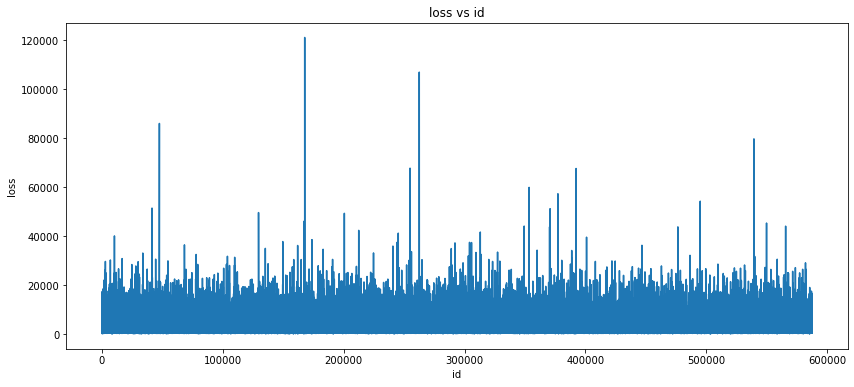

In [19]:
plt.figure(figsize=(14,6))
plt.plot(train_data['id'],train_data['loss'])
plt.xlabel('id')
plt.ylabel('loss')
plt.title('loss vs id')
plt.show()

## Observation:
* we can notice that there are several spikes in the plot of loss feature which represents a huge loss at some time.
* As there are many peaks that we notice we can say that the actual data of this feature is skewed and this can result in suboptimal performance of regression models that we build.
* skewed data effects a lof in your performance.

## Calculate skewness and see how we can reduce skewness.

In [20]:
a = train_data['loss'].skew()
print('Skewness of loss feature is :',a)

Skewness of loss feature is : 3.7949583775378604


In [21]:
train_data['logloss'] = np.log(train_data['loss'])
print('Skewness of loss feature after applying log function :',train_data['logloss'].skew())
train_data = train_data.drop(['logloss'],axis = 1)

Skewness of loss feature after applying log function : 0.09297454555136214


## Observation:
* we can see that there is a lot of skewness in the target variable and this will result in wrong predictions.
* we applied log transformation over that target variable and noticed that skewness has decreased a lot.

## Plots for target variable before and after log transformation

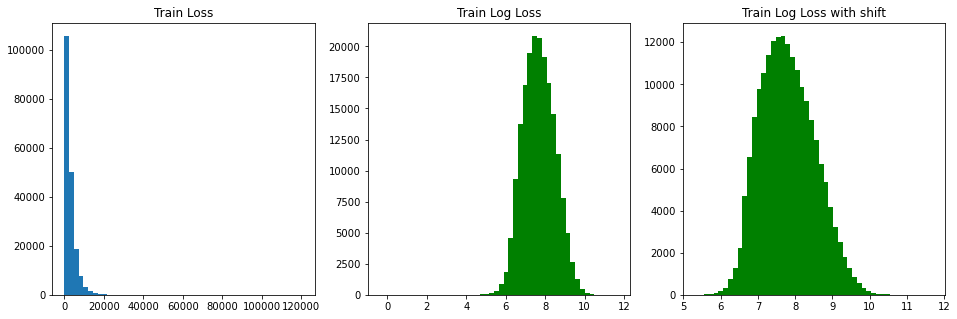

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(16,5)

ax1.hist(train_data['loss'], bins=50)
ax1.set_title('Train Loss')

ax2.hist(np.log(train_data['loss']), bins=50, color='g')
ax2.set_title('Train Log Loss')

ax3.hist(np.log(train_data['loss']+200), bins=50, color='g')
ax3.set_title('Train Log Loss with shift')
plt.show()

## Observation:
* First plot consists of target variable distribution with the actual values given in the data set. we noticed that the distribution is not uniform.
* second plot consists of loss feature after applying log transformation adn we cna observe that this distribution is kind of normal distribution. although mean is not centered to zero , its a lot batter than actual target values in the given dataset.
* When we added a shift value of 200 we can see that the distribution is actually very nice.

## Box plot of target variable

Text(0.5, 1.0, 'Zoomed version of loss feature')

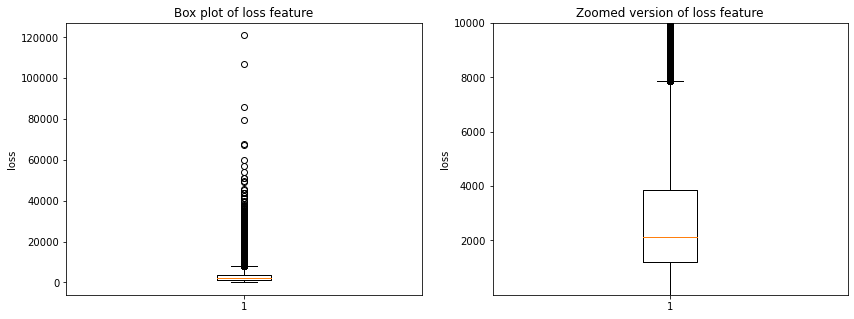

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(14,5)
ax1.boxplot(train_data['loss'])
ax1.set_ylabel('loss')
ax1.set_title('Box plot of loss feature')


#values = uniq_values_in_categories[uniq_values_in_categories.unique_values <= 25].unique_values
ax2.set_ylim(1,10000)
ax2.boxplot(train_data['loss'])
ax2.set_ylabel('loss')
ax2.set_title('Zoomed version of loss feature')

## Observation:
* We can immeditely notice that most of the 25, 50 ,75 th percentile values are very less. There are a couple of points where loss is very high, usuallly we treat those as outliers but in this case we have to handle those as at that point the company incurred a huge loss. 
* we should be very careful that we dont overfit our model because of these kinds of points. 

## Checking Train and Test distributions
* We need to check weather both train and test data are from siilar distributions or not. If we do confirm that data is distributed equally we can do test train split for cv as well
* There are so many techniques to check distributions on train and test like welchs test, but they need to be done on feature by feature checking.
* so what we will do is merge both test and train data, include a new target variable as 1 for train and 0 for test data and build a model.
* if model performs very bad that means both came from similar distributions.

### Preparing the data

In [24]:
#Removing last column in test data which we need to predict. It has Nan values in the given dataset.
train_data_dropped = train_data.drop(['id','loss'], axis=1)
test_data_dropped  = test_data.drop(['id'], axis=1)

print('Shape of Train data :',train_data_dropped.shape)
print('Shape of Test  data :',test_data_dropped.shape)

Shape of Train data : (188318, 130)
Shape of Test  data : (125546, 130)


In [25]:
#Now we create a label for test and train data as 0 , 1 respectively.
train_data_dropped['target'] = 1
test_data_dropped['target'] = 0
final_df = pd.concat((train_data_dropped,test_data_dropped))

In [26]:
data_label_encode = deepcopy(final_df)
for c in range(len(categorical_features)):
    data_label_encode[categorical_features[c]] = data_label_encode[categorical_features[c]].astype('category').cat.codes
print('Shape of data after Label Encoding is  :',data_label_encode.shape)

Shape of data after Label Encoding is  : (313864, 131)


In [27]:
# One hot encoding and dropping index
data_ohe = pd.get_dummies(data=data_label_encode, columns=categorical_features)
data_ohe.reset_index(drop = True, inplace = True)
print('Shape of data after OHE :',data_ohe.shape)

Shape of data after OHE : (313864, 1191)


In [28]:
# Shuffling the rows in dataset
from sklearn.utils import shuffle
data_label_encode = shuffle(data_label_encode)

In [29]:
x = data_label_encode.drop(['target'],axis = 1)
y = data_label_encode.target

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test =  train_test_split(x,y,test_size = 0.3)

print('shape of x_train : ',x_train.shape)
print('shape of y_train : ',y_train.shape)
print('shape of x_test  : ',x_test.shape)
print('shape of y_test  : ',y_test.shape)

shape of x_train :  (219704, 130)
shape of y_train :  (219704,)
shape of x_test  :  (94160, 130)
shape of y_test  :  (94160,)


## Building A model

In [30]:
model = LogisticRegression()
model.fit(x_train,y_train)
predicted_value = model.predict(x_test)
auc = AUC(y_test, predicted_value)
print("Logistic Regression AUC score is : {:.2%}".format(auc))

Logistic Regression AUC score is : 50.00%


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [31]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model.fit(x_train, y_train)
predicted_value = model.predict(x_test)
auc = AUC(y_test, predicted_value)
print("Random Forest AUC: {:.2%}".format(auc))

Random Forest AUC: 50.13%


## Observation
* As you can see both Linear Regression and Random Forest model gives an AUC of 50%. so we can say that both train and test data have similar distributions and it is hard to seperate both when mixed together.


## Feature Importance

In [32]:
# https://github.com/brunocampos01/allstate-claims-severity/blob/master/notebooks/1-data-exploration-and-data-cleaning.ipynb

features = [col for col in train_data.columns if col not in ['id','loss']]
feature_imp_dict = dict(zip(features,model.feature_importances_))
imp_features = sorted(feature_imp_dict,key=feature_imp_dict.get, reverse=True)
imp_feature_values = [feature_imp_dict[x] for x in imp_features]

fea_imp_df = pd.DataFrame(data={'feature': imp_features, 'importance': imp_feature_values})
print(fea_imp_df.head())

  feature  importance
0  cont14    0.078168
1  cat112    0.053026
2   cont7    0.038814
3  cat100    0.038733
4   cont6    0.029449


[Text(0, 0.5, 'Importance'),
 Text(0.5, 0, 'Feature Name'),
 Text(0.5, 1.0, 'Variable Importances')]

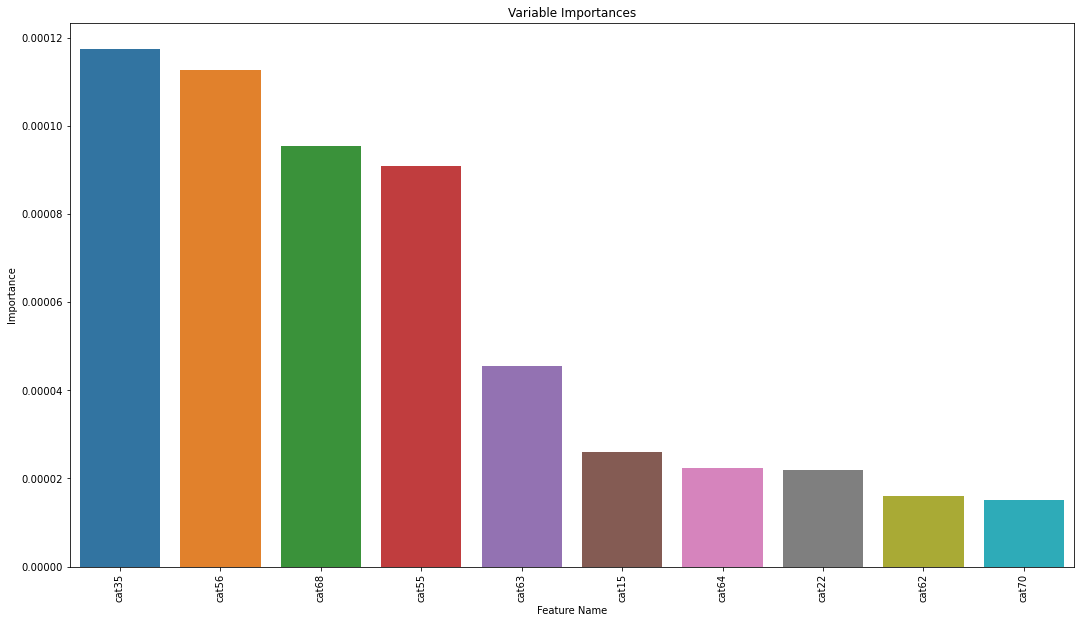

In [33]:
fig,ax = plt.subplots()
plt.xticks(rotation='vertical')

fig.set_size_inches(18,10)
sns.barplot(data=fea_imp_df.iloc[-10:], 
            x="feature", 
            y="importance", 
            ax=ax)
ax.set(xlabel="Feature Name",
       ylabel='Importance',
       title="Variable Importances")

## Observation:
* You cn observe that last few features lik cat62,cat64,ct70,cat22,...... these have very less feature importance when you trained model on combined test data and train data.

## PCA 

In [34]:
pd.set_option('display.max_columns', 1000)
#pd.set_option('display.max_rows',1000)

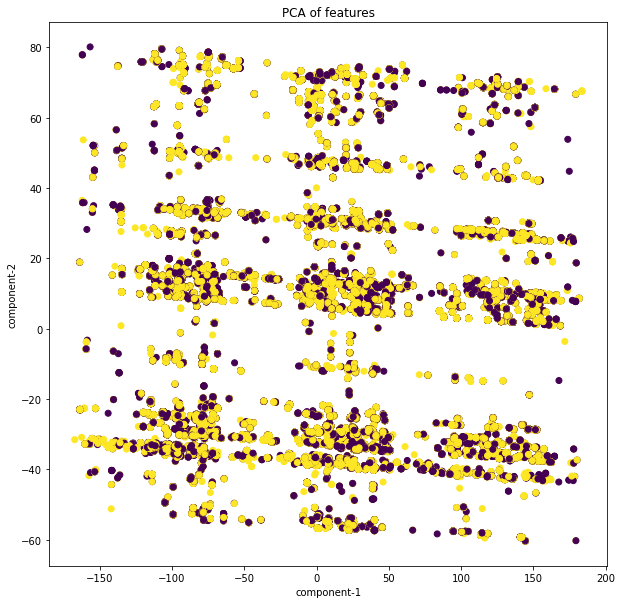

In [35]:
data_label_encode = shuffle(data_label_encode)
X = data_label_encode.iloc[:, :130]
Y = data_label_encode.iloc[:, 130:]
pca = PCA(n_components = 2)
reduced_X = pca.fit_transform(X)

plt.figure(figsize = (10,10))
plt.scatter(reduced_X[:,0],reduced_X[:,1],c = np.array(y))
plt.title('PCA of features')
plt.xlabel('component-1')
plt.ylabel('component-2')
plt.show()

## Observation:
* we can notice that we can t seperate data easily even with PCA that embedded on 2 components.